## Implementing binary decision trees with real valued features
**Multi class supported - Classes IDs are 0 through C**

In [67]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

### Generate a fake dataset 

In [27]:
#artificial training dataset
Xtrain = np.random.rand(1000,10)
y = np.ones(1000).astype(int)
y[(Xtrain[:,0] < 0.25)] = 0
y[(Xtrain[:,1] > 0.55)] = 2
np.unique(y)

array([0, 1, 2])

### A linearly separable dataset

In [60]:
Xtrain = np.random.rand(1000,10)
y = np.ones(1000).astype(int)
y[(Xtrain[:,0]+Xtrain[:,1]+Xtrain[:,2] < 1)] = 0
y[(Xtrain[:,0]+3*Xtrain[:,2] >= 1.5)] = 2
y[(1.5*Xtrain[:,0]-2*Xtrain[:,1]+Xtrain[:,2] < 1)] = 3

### Another fake dataset with more features

In [506]:
X,y = make_classification(n_samples=2000,n_features=10,n_informative=5,n_classes=2)
print X.shape
print np.unique(y) #original labels are 0 and 1
ind = y==0
y[ind] = -1
print np.unique(y)

(2000, 10)
[0 1]
[-1  1]


## Train-test split + Split test data into target1 (for expansion) and target2 (for reduction)

In [507]:
X_source, X_test, y_source, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print X_source.shape

(1340, 10)


In [508]:
X_target1, X_target2, y_target1, y_target2 = train_test_split(X_test,y_test)
print X_target1.shape

(495, 10)


# Decision tree implementation

### Function to count number of mistakes while predicting majority class

Recall from the lecture that prediction at an intermediate node works by predicting the **majority class** for all data points that belong to this node.

Now, we will write a function that calculates the number of **missclassified examples** when predicting the **majority class**. This will be used to help determine which feature is the best to split on at a given node of the tree.

**Note**: Keep in mind that in order to compute the number of mistakes for a majority classifier, we only need the label (y values) of the data points in the node. 

** Steps to follow **:
* ** Step 1:** Calculate the number of +1 and -1
* ** Step 2:** Since we are assuming majority class prediction, all the data points that are **not** in the majority class are considered **mistakes**.
* ** Step 3:** Return the number of **mistakes**.

Now, let us write the function `intermediate_node_num_mistakes` which computes the number of misclassified examples of an intermediate node given the set of labels (y values) of the data points contained in the node. 

In [28]:
def intermediate_node_num_mistakes(labels_in_node):
    
    # Corner case: If labels_in_node is empty, return 0
    if len(labels_in_node) == 0:
        return 0
    
    C,unique_counts = np.unique(labels_in_node,return_counts=True) #the id of classes and number of each
    
    return (len(labels_in_node) - unique_counts[np.argmax(unique_counts)])    

In [29]:
def reached_minimum_node_size(y, min_node_size):
    # Return True if the number of data points is less than or equal to the minimum node size.
    if y.shape[0] <= min_node_size:
        #print y.shape[0]
        return True

## Function to pick best feature to split on

The function **best_splitting_feature** takes 2 arguments: 
1. The feature matrix X [N datapoints x p features]
2. The vector of labels [N x 1]

Recall that the **classification error** is defined as follows:
$$
\mbox{classification error} = \frac{\mbox{# mistakes}}{\mbox{# total examples}}
$$

* The second implementation uses the Information Gain to find the optimal split and bins the data into 10 bins

In [143]:
# X matrix of features (p datapoints x N features)
# y vector of labels (p x 1)

def best_splitting_feature(X, y, Nbins):
        
    best_feature = None # Keep track of the best feature 
    best_threshold = None
    best_I = -1     # Keep track of the best info gain so far 

    #the number of data points in the parent node
    num_data_points = y.shape[0]
    
    # Loop through each feature to consider splitting on that feature
    for feature in range(X.shape[1]):
        
        fvals = X[:,feature]
        fvals = np.sort(fvals)  #sorting the values
        if num_data_points > Nbins:            
            fvals = fvals[range(0,num_data_points,Nbins)]
        #else:
        #    fvals = fvals[1:-1] #exclude the first and last data point to prevent empty splits

        
        #loop through all values of current feature to find the best split
        for threshold in fvals:

            # The left split will have all data points where the feature value is smaller than threshold
            ind_left = np.where(X[:,feature] < threshold)
            left_split = np.squeeze(X[X[:,feature] < threshold])
            if np.array(ind_left).shape[1]==0:
                #print 'left split empty'
                continue

            # The right split will have all data points where the feature value is larger or equal
            ind_right = np.where(X[:,feature] >= threshold)
            right_split = np.squeeze(X[X[:,feature] >= threshold])
            if np.array(ind_right).shape[1]==0:
                #print 'right split empty'
                continue
            
            #compute info-gain for current feature and threshold split
            I = infogain(y,y[ind_left],y[ind_right])
            
            # If this is the best error we have found so far, store the feature as best_feature
            # the threshold as the best threshold and the error as best_error
            if I > best_I:
                best_feature = feature
                best_threshold = threshold
                best_I = I
        
    return best_feature, best_threshold # Return the best feature and threshold

In [141]:
def infogain(yparent,yleft,yright):
    
    Nparent = len(yparent)
    Nleft = len(yleft)
    Nright = len(yright)
    
    if Nleft ==0 or Nright == 0:
        I = 0
    else:
        #information gain
        I = entropy(yparent) -( (Nleft/Nparent)*entropy(yleft) + (Nright/Nparent)*entropy(yright) )   

    return I


In [142]:
#entropy for multiple classes
def entropy(y):
    C,unique_counts = np.unique(y,return_counts=True) #the id of classes and number of each
    Pc = unique_counts/len(y)
    H = -(Pc*np.log(Pc)).sum()
    return H    

## Building the tree

With the above functions implemented correctly, we are now ready to build our decision tree. Each node in the decision tree is represented as a dictionary which contains the following keys and possible values:

    { 
       'is_leaf'            : True/False.
       'prediction'         : Prediction at the leaf node.
       'left'               : (dictionary corresponding to the left tree).
       'right'              : (dictionary corresponding to the right tree).
       'splitting_feature'  : The feature that this node splits on.
    }

First, we will write a function that creates a leaf node given a set of target values. Fill in the places where you find `## YOUR CODE HERE`. There are **three** places in this function for you to fill in.

In [33]:
def create_leaf(target_values,C):

    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'is_leaf': True,
            'prediction': None,
            'labels_distribution':None                       }   
    
    # Count the number of data points of each class in the leaf.
    C_in_node,unique_counts = np.unique(target_values,return_counts=True) #the id of classes and number of each
    leaf['prediction'] = C_in_node[np.argmax(unique_counts)]
    
    Classes = np.zeros(C)
    Classes[C_in_node] = unique_counts/len(target_values)
    leaf['labels_distribution'] = Classes
    
    # Return the leaf node        
    return leaf 

In [138]:
def decision_tree_create(X, y, N_features_to_sample, C, min_node_size, Nbins, current_depth = 0, max_depth = 10, Verbose = False):
    
    #randomly sample a subset of features
    Nfeatures = X.shape[1]
    features = np.random.choice(Nfeatures, N_features_to_sample, replace=False)    
    
    #select only the features sampled for this run
    Xcurrent = X[:,features]
    target_values = y

    if Verbose == True:
        print "--------------------------------------------------------------------"
        print "Subtree, depth = %s (%s data points)." % (current_depth, len(target_values))
        print "Features selected = %s" % features


    # Stopping condition 1
    # (Check if there are mistakes at current node, i.e. if the node is pure.)
    if intermediate_node_num_mistakes(target_values) == 0:  
        #print "No Mistakes at current node - Stopping."     
        # If not mistakes at current node, make current node a leaf node
        return create_leaf(target_values,C)
    
    #Stopping condition 2: min node size reached
    if reached_minimum_node_size(y, min_node_size):
        #print "Minimum node size reached - Stopping"
        return create_leaf(y,C)
    
    # Stopping condition 3: (limit tree depth)
    if current_depth >= max_depth:  
        #print "Reached maximum depth. Stopping for now."
        # If the max tree depth has been reached, make current node a leaf node
        return create_leaf(target_values,C)

    # Find the best splitting feature and its threshold
    splitting_feature,splitting_thres = best_splitting_feature(Xcurrent,y, Nbins)
    splitting_feature = features[splitting_feature]
    
    # Split on the best feature that we found. 
    try:
        ind_left = X[:,splitting_feature] < splitting_thres
        left_split = X[ind_left,:]
        y_left = y[ind_left]
            
        ind_right = X[:,splitting_feature] >= splitting_thres
        right_split = X[ind_right,:]
        y_right = y[ind_right]
        
    except IndexError: 
        print Xcurrent.shape
        print range(Xcurrent.shape[1])
        print ind_left.shape
        print splitting_feature
        print splitting_thres

    if Verbose == True:
        print "Split on feature %s. (%s, %s), Threshold = %s" % (\
        splitting_feature, y_left.shape, y_right.shape, splitting_thres)
    
    # Create a leaf node if the split is "perfect"
    if y_left.shape == y.shape[0]:
        #print "Creating leaf node."
        return create_leaf(y_left,C)
    if y_right.shape == y.shape[0]:
        #print "Creating leaf node."
        return create_leaf(y_right,C)
        
    # Repeat (recurse) on left and right subtrees
    left_tree = decision_tree_create(left_split, y_left, N_features_to_sample, C, min_node_size, Nbins, current_depth + 1, max_depth)        
    right_tree = decision_tree_create(right_split, y_right, N_features_to_sample, C, min_node_size, Nbins, current_depth + 1, max_depth)

    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'threshold'        : splitting_thres,
            'left'             : left_tree, 
            'right'            : right_tree,
            'labels_distribution': None 
            
            }

Here is a recursive function to count the nodes and leaves in your tree:

In [35]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [36]:
def count_leaves(tree):
    if tree['is_leaf']:
        return 1 
    return count_leaves(tree['left']) + count_leaves(tree['right'])
        

### Function to create and train a new forest

In [144]:
def forest_create(X,y,ntrees,nvarsample=None, min_node_size = 5, Nbins = 10):
    
    if nvarsample == None:
        nvarsample = (np.round(np.sqrt(X.shape[1]))).astype(int)
        print 'Nfeatures = %s'%nvarsample
    
    #the number of classes is inferred from the data
    C = len(np.unique(y))
    
    nptrain = X.shape[0] #how many datapoints each tree is trained (same size of X)
    RF = []
    #for loop creating and training each tree 
    #bootstrap X to train each tree
    for t in range(ntrees):
        print 'current trained tree = %s'%t
        #create bootstrap training dataset for tree t
        indbootstrap = np.random.choice(X.shape[0],nptrain)
        Xtree = X[indbootstrap,:]
        ytree = y[indbootstrap] 
        
        #train the tree
        tree1 = decision_tree_create(Xtree,ytree,nvarsample,C,min_node_size,Nbins,max_depth=20,Verbose=True)
        RF.append(tree1)
    
    print 'Forest Trained!'
    return RF
        

In [121]:
RF = forest_create(Xtrain,y,10)

Nfeatures = 3
current trained tree = 0
--------------------------------------------------------------------
Subtree, depth = 0 (1000 data points).
Features selected = [5 1 9]
Split on feature 1. ((320,), (680,)), Threshold = 0.313990808468
current trained tree = 1
--------------------------------------------------------------------
Subtree, depth = 0 (1000 data points).
Features selected = [0 4 5]
Split on feature 0. ((730,), (270,)), Threshold = 0.719011911974
current trained tree = 2
--------------------------------------------------------------------
Subtree, depth = 0 (1000 data points).
Features selected = [4 5 8]
Split on feature 4. ((989,), (11,)), Threshold = 0.99562301734
current trained tree = 3
--------------------------------------------------------------------
Subtree, depth = 0 (1000 data points).
Features selected = [3 8 4]
Split on feature 8. ((940,), (60,)), Threshold = 0.943912072456
current trained tree = 4
------------------------------------------------------------

## Making predictions with a decision tree

In [39]:
def classify(tree, x):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        return tree['labels_distribution'] 
    else:
        # split on feature.
        val_split_feature = x[tree['splitting_feature']]
        if val_split_feature < tree['threshold']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'],x)

In [40]:
#outputs the posterior prob of each tree and the corresponding class
def forest_posterior(RF,x):

    T = len(RF)  #the number of trees 

    #infer the number of classes
    P0 = classify(RF[0],x)
    C = len(P0)
    
    Pt = np.zeros((T,C)) #matrix of posteriors from each tree (T x Nclasses)
    Pt[0,:] = P0
    for t in range(len(RF))[1:]:
        Pt[t,:] = classify(RF[t],x) 
    return Pt
    

In [41]:
#classify input based on majority voting of each tree prediction
def forest_classify_majority(RF,x):
        Pt = forest_posterior(RF,x)
        Yt = np.argmax(Pt,axis=1)         
        C,unique_counts = np.unique(Yt,return_counts=True) #the id of classes and number of each
        return C[np.argmax(unique_counts)]    

In [53]:
#classify input by averaging posteriors 
def forest_classify_ensemble(RF,x):
    Pt = forest_posterior(RF,x)
    Pforest = Pt.mean(axis=0)
    ypred = np.argmax(Pt.mean(axis=0))
    return ypred

In [54]:
def evaluate_classification_error(RF, X, y, method = None):
    
    # Apply the forest_classify(RF, x) to each row in your data
    if method == None:
        ypred = map(lambda x: forest_classify_ensemble(RF,x), X)
        # Once you've made the predictions, calculate the classification error and return it
        mistakes = sum(ypred != y)
        error = mistakes/len(y)
    return error

In [62]:
evaluate_classification_error(RF,Xtrain,y)

0.002

In [58]:
x= Xtrain[101,:]
print forest_posterior(RF,x)
print y[101]

print forest_classify_majority(RF,x)
print forest_classify_ensemble(RF,x)

[[ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.5  0.   0.5]
 [ 0.   1.   0. ]
 [ 0.   1.   0. ]
 [ 0.   0.   1. ]]
1
1
1


### Test Random Forest on the MNIST dataset

In [78]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=False)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


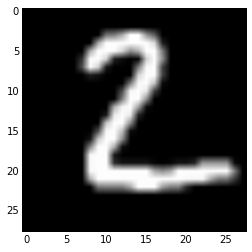

In [79]:
xtest = mnist.test.images[1,:]
xtest = xtest.reshape(28,28)
plt.imshow(xtest,'gray')

In [81]:
xtrain = mnist.train.images
xtest = mnist.test.images
ytrain = mnist.train.labels
ytest = mnist.test.labels
print xtrain.shape
print xtest.shape
print ytrain.shape
print np.unique(ytrain)

(55000, 784)
(10000, 784)
(55000,)
[0 1 2 3 4 5 6 7 8 9]


In [84]:
xtest

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [145]:
RF_MNIST = forest_create(xtest,ytest,10)

Nfeatures = 28
current trained tree = 0
--------------------------------------------------------------------
Subtree, depth = 0 (10000 data points).
Features selected = [ 81 734 589 187 509 322 441 377  74 659 332 237 173 331 204 324 143 492
 766 679 104 732 776 465 630 229 636 189]
Split on feature 377. ((4573,), (5427,)), Threshold = 0.0235294
current trained tree = 1
--------------------------------------------------------------------
Subtree, depth = 0 (10000 data points).
Features selected = [593 592 521 451  14 269 745  27 444  38 135 386 105 394  51 514  64 605
 406 404 223 776 711 194   9   5 470 511]
Split on feature 406. ((4389,), (5611,)), Threshold = 0.376471
(20, 28)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
(20, 1, 28)
[[367 388 661 712 426 759 604 200  86  85 713 450   7  75 220 282 116 219
  536 770 218 778 530 696   6 665 528 168]]
None


UnboundLocalError: local variable 'y_left' referenced before assignment

In [ ]:
a = np.array([1,2,3])
b = np.array([1,2])<2
print b
print a[b]

#### compute the path to the leaf followed by data point x  

In [61]:
def datapath(tree, x, branch = 1):   
    # if the node is a leaf node.
    if tree['is_leaf']:
        return branch 
    else:
        # split on feature.
        split_feature_value = x[tree['splitting_feature']]

        if split_feature_value == 0:
            
            return datapath(tree['left'], x, 2*branch)
        else:
            return datapath(tree['right'],x, 2*branch+1)

## Expansion/Reduction functions for the transfer forest

#### Local Expansion/Reduction of the tree

In [116]:
def expansion_reduction(tree,dataT1,dataT2,features,target):

    Tree = tree #a copy of the tree
    
    leavesData1 = np.zeros(len(dataT1))
    leavesData2 = np.zeros(len(dataT2))
    
    for i in range(len(dataT1)):
        leavesData1[i]=  datapath(tree,dataT1[i]) #indicates the leaf where each data point ends up
    for i in range(len(dataT2)):
        leavesData2[i]=  datapath(tree,dataT2[i]) #indicates the leaf where each data point ends up
        
    Uleaves1 = np.unique(leavesData1)  #the path to each leaf followed by data1
    Uleaves2 = np.unique(leavesData2)  #the path to each leaf followed by data2
    Uleaves = list(set(Uleaves1) & set(Uleaves2)) #leaves reached by both data1 and data2
            
    #expanding each leaf on the 1st bootstrap replica of target data
    for i in Uleaves:
        ind_data1 = np.where(leavesData1==i) #indices of datapoints for each leaf
        print ind_data1
        Exp_tree = decision_tree_create(dataT1[ind_data1], features, 'safe_loans', max_depth = 3)

        #classification error at each leaf for Data T2
        ind_data2 = np.where(leavesData2==i)
        Err_leavesT2 = intermediate_node_num_mistakes(dataT2[ind_data2][target])/len(dataT2[ind_data2])

        #error at the current subtree on Data T2
        Err_subtreeT2 = evaluate_classification_error(Exp_tree, dataT2[ind_data2])
        
        #comparing the error of the subtree with that at the leaf node of the original tree
        if Err_subtreeT2 < Err_leavesT2:
            Tree = mergetrees(Tree,i,Exp_tree)
    
    return Tree

In [105]:
def mergetrees(tree1,leafnr,tree2):
    leafnrbin = bin(leafnr)[3:]
    path = ''
    for i in range(len(leafnrbin)):
        if leafnrbin[i] == '0':
            path=path+str("['left']")
        else:
            path=path+str("['right']") 
        print(path)
    exec ('tree1'+path+"['prediction']"+'=None')
    exec ('tree1'+path+"['is_leaf']"+'=False')
    exec ('tree1'+path+"['left']"+"=tree2['left']")
    exec ('tree1'+path+"['right']"+"=tree2['right']")
    exec ('tree1'+path+"['splitting_feature']"+"=tree2['splitting_feature']")
    
#    print ('tree1'+path+"['prediction']"+'=None')
#    print ('tree1'+path+"['is_leaf']"+'=False')
#    print ('tree1'+path+"['left']"+"=tree2['left']")
#    print ('tree1'+path+"['right']"+"=tree2['right']")
#    print ('tree1'+path+"['splitting_feature']"+"=tree2['splitting_feature']")
    
    #print('tree1'+path+'=tree2')
    return tree1
    

## Printing out a decision stump (To be updated to the numpy version!)

In [119]:
def print_stump(tree, name = 'root'):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print "(leaf, label: %s)" % tree['prediction']
        return None
    split_feature, split_value = split_name.split('.')
    print '                       %s' % name
    print '         |---------------|----------------|'
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '  [{0} == 0]               [{0} == 1]    '.format(split_name)
    print '         |                                |'
    print '         |                                |'
    print '         |                                |'
    print '    (%s)                         (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree'))

In [120]:
print_stump(my_decision_tree)

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term. 36 months == 0]               [term. 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (subtree)


### Exploring the intermediate left subtree

The tree is a recursive dictionary, so we do have access to all the nodes! We can use
* `my_decision_tree['left']` to go left
* `my_decision_tree['right']` to go right

In [121]:
print_stump(my_decision_tree['left'], my_decision_tree['splitting_feature'])

                       term. 36 months
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.A == 0]               [grade.A == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (subtree)


### Exploring the left subtree of the left subtree


In [122]:
print_stump(my_decision_tree['left']['left'], my_decision_tree['left']['splitting_feature'])

                       grade.A
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.B == 0]               [grade.B == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (subtree)


In [128]:
print_stump(my_decision_tree['right'], my_decision_tree['splitting_feature'])

                       term. 36 months
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade.D == 0]               [grade.D == 1]    
         |                                |
         |                                |
         |                                |
    (subtree)                         (leaf, label: -1)
